# Lattice Examples

In [1]:
using Combinatorics
using CSV
using DataFrames
using Plots
using LinearAlgebra
using Unitful

In [2]:
# Global variables
kB = 8.617333262e-5  # eV/K

8.617333262e-5

In [3]:
abstract type LatticeWalkers end

function compute_neighbors(supercell_lattice_vectors::Matrix{Float64}, positions::Matrix{Float64}, cutoff_radii::Tuple{Float64, Float64})
    neighbors = Vector{Tuple{Vector{Int}, Vector{Int}}}(undef, size(positions, 1))
    num_atoms = size(positions, 1)
    
    # Compute reciprocal lattice vectors for minimum image convention
    a1 = supercell_lattice_vectors[:, 1]
    a2 = supercell_lattice_vectors[:, 2]
    reciprocal_lattice_vectors = inv([a1 a2])

    first_nearest_distance = cutoff_radii[1]
    second_nearest_distance = cutoff_radii[2]

    for i in 1:num_atoms
        first_neighbors = Int[]
        second_neighbors = Int[]
        pos_i = positions[i, :]
        
        for j in 1:num_atoms
            if i != j
                pos_j = positions[j, :]
                dx = pos_j[1] - pos_i[1]
                dy = pos_j[2] - pos_i[2]

                # Apply minimum image convention using reciprocal lattice vectors
                dr = [dx, dy]
                fractional_dr = reciprocal_lattice_vectors * dr
                fractional_dr .= fractional_dr .- round.(fractional_dr)
                dr = supercell_lattice_vectors * fractional_dr

                distance = norm(dr)
                
                if distance <= first_nearest_distance
                    push!(first_neighbors, j)
                elseif distance <= second_nearest_distance
                    push!(second_neighbors, j)
                end
            end
        end
        
        neighbors[i] = (first_neighbors, second_neighbors)
    end
    
    return neighbors
end

mutable struct Lattice2DSystem
    lattice_vectors::Matrix{Float64}
    positions::Matrix{Float64}
    supercell_dimensions::Tuple{Int64, Int64}
    occupations::Vector{Bool}
    neighbors::Vector{Tuple{Vector{Int}, Vector{Int}}}

    function Lattice2DSystem(lattice_vectors::Matrix{Float64}, basis::Vector{Tuple{Float64, Float64}}, supercell_dimensions::Tuple{Int64, Int64}, occupations::Vector{Bool}, cutoff_radii::Tuple{Float64, Float64})
        num_basis_sites = length(basis)
        num_supercell_sites = supercell_dimensions[1] * supercell_dimensions[2] * num_basis_sites
        
        positions = zeros(Float64, num_supercell_sites, 2)
        index = 1

        a1 = lattice_vectors[:, 1]
        a2 = lattice_vectors[:, 2]

        for j in 1:supercell_dimensions[2]
            for i in 1:supercell_dimensions[1]
                for (bx, by) in basis
                    x = (i - 1) * a1[1] + (j - 1) * a2[1] + bx
                    y = (i - 1) * a1[2] + (j - 1) * a2[2] + by
                    positions[index, :] = [x, y]
                    index += 1
                end
            end
        end

        if length(occupations) != size(positions, 1)
            throw(ArgumentError("Length of occupations vector must match the number of lattice sites"))
        end

        neighbors = compute_neighbors(lattice_vectors * Diagonal([supercell_dimensions[1], supercell_dimensions[2]]), positions, cutoff_radii)
        
        return new(lattice_vectors, positions, supercell_dimensions, occupations, neighbors)
    end
end

mutable struct Lattice2DWalker
    configuration::Lattice2DSystem
    energy::Float64
    iter::Int64
    function Lattice2DWalker(configuration::Lattice2DSystem; energy=0.0, iter=0)
        return new(configuration, energy, iter)
    end
end

function interaction_energy(at::Lattice2DSystem, adsorption_energy::Float64, nn_energy::Float64, nnn_energy::Float64)
    e_adsorption = sum(at.occupations) * adsorption_energy
    e_nn = 0.0
    e_nnn = 0.0

    for index in 1:length(at.occupations)
        if at.occupations[index]
            # Compute nearest-neighbor interaction energy
            for nn in at.neighbors[index][1]
                if at.occupations[nn]
                    e_nn += nn_energy / 2
                end
            end

            # Compute next-nearest-neighbor interaction energy
            for nnn in at.neighbors[index][2]
                if at.occupations[nnn]
                    e_nnn += nnn_energy / 2
                end
            end
        end
    end

    return e_adsorption + e_nn + e_nnn
end

function exact_enumeration(primitive_lattice_vectors::Matrix{Float64}, basis::Vector{Tuple{Float64, Float64}}, supercell_dimensions::Tuple{Int64, Int64}, number_occupied_sites::Int64, adsorption_energy::Float64, nn_energy::Float64, nnn_energy::Float64, cutoff_radii::Tuple{Float64, Float64})
    L, M = supercell_dimensions
    num_basis_sites = length(basis)
    N = L * M * num_basis_sites

    # Generate all possible occupation configurations
    all_configs = collect(combinations(1:N, number_occupied_sites))

    # Generate occupation vectors from configurations
    all_occupation_vectors = Vector{Vector{Bool}}()
    for config in all_configs
        occupations = falses(N)
        occupations[config] .= true
        push!(all_occupation_vectors, Vector{Bool}(occupations))  # Convert BitVector to Vector{Bool}
    end

    # Generate Lattice2DSystem objects for each configuration
    lattices = [Lattice2DSystem(primitive_lattice_vectors, basis, supercell_dimensions, occupations, cutoff_radii) for occupations in all_occupation_vectors]

    # Generate Lattice2DWalker objects for each lattice system
    walkers = [Lattice2DWalker(lattice) for lattice in lattices]

    # Compute energies for each walker
    for walker in walkers
        e_interaction = interaction_energy(walker.configuration, adsorption_energy, nn_energy, nnn_energy)
        walker.energy = e_interaction
    end

    # Extract energies and configurations
    energies = [walker.energy for walker in walkers]
    configurations = [walker.configuration for walker in walkers]

    return energies, configurations
end

function plot_lattice(lattice::Lattice2DSystem, title::String)
    plot_lattice = plot(title=title, legend=false, aspect_ratio=:equal)
    num_positions = size(lattice.positions, 1)
    
    for index in 1:num_positions
        x, y = lattice.positions[index, :]
        scatter!(plot_lattice, [x], [y], color=:blue, markersize=10)
        annotate!(plot_lattice, x, y, text(index, 10, :white))
    end
    
    return plot_lattice
end

function print_lattice_info(lattice::Lattice2DSystem)
    println("Lattice2DSystem Information:")
    println("Supercell Dimensions: ", lattice.supercell_dimensions)
    println("Lattice Vectors:")
    println(lattice.lattice_vectors)
    println("Positions:")
    for i in 1:size(lattice.positions, 1)
        println("  Atom $i: (", lattice.positions[i, 1], ", ", lattice.positions[i, 2], ")")
    end
    println("Occupations: ", lattice.occupations)
    println("Neighbors:")
    for i in 1:length(lattice.neighbors)
        first_neighbors, second_neighbors = lattice.neighbors[i]
        println("  Atom $i: First Neighbors - ", first_neighbors, ", Second Neighbors - ", second_neighbors)
    end
end

function partition_function(β::Float64, 
                            ωi::Vector{Float64}, 
                            Ei::Vector{Float64})
    z = sum(ωi.*exp.(-Ei.*β))
    return z
end

function internal_energy(β::Float64, 
                         ωi::Vector{Float64}, 
                         Ei::Vector{Float64})
    u = sum(ωi.*Ei.*exp.(-Ei.*β))/sum(ωi.*exp.(-Ei.*β))
    return u
end

function cv(β::Float64,
            ωi::Vector{Float64}, 
            Ei::Vector{Float64},
            dof::Int64)
    z = partition_function(β, ωi, Ei)
    u = internal_energy(β, ωi, Ei)
    kb = 8.617333262e-5 # eV/K
    cv = dof*kb/2.0 + kb*β^2 * (sum(ωi.*Ei.^2 .*exp.(-Ei.*β))/z - u^2)
    return cv
end


cv (generic function with 1 method)

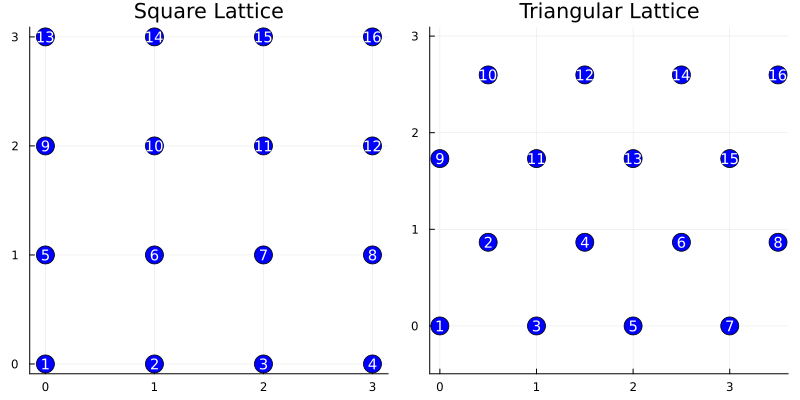

In [4]:
# Define a square lattice
square_lattice_constant = 1.0
square_primitive_lattice_vectors = [square_lattice_constant 0.0; 0.0 square_lattice_constant]
square_basis = [(0.0, 0.0)]
square_supercell_dimensions = (4, 4)
square_occupations = [true for i in 1:16]
square_cutoff_radii = (1.1, 1.5)
square_lattice = Lattice2DSystem(square_primitive_lattice_vectors, square_basis, square_supercell_dimensions, square_occupations, square_cutoff_radii)
# print_lattice_info(square_lattice)

# Define a triangular Lattice
triangular_lattice_constant = 1.0
triangular_primitive_lattice_vectors = [triangular_lattice_constant 0.0; 0.0 sqrt(3) * triangular_lattice_constant]
triangular_basis = [(0.0, 0.0), (1/2, sqrt(3)/2)]
triangular_supercell_dimensions = (4, 2)
triangular_occupations = [true for i in 1:16]
triangular_cutoff_radii = (1.1, 1.1)
triangular_lattice = Lattice2DSystem(triangular_primitive_lattice_vectors, triangular_basis, triangular_supercell_dimensions, triangular_occupations, triangular_cutoff_radii)
# print_lattice_info(triangular_lattice)

# Plot the lattice
plot_square = plot_lattice(square_lattice, "Square Lattice")
plot_hexagonal = plot_lattice(triangular_lattice, "Triangular Lattice")
plot(plot_square, plot_hexagonal, layout=(1, 2), size=(800, 400))

## Square Lattice

In [5]:
# Define the parameters for the exact enumeration
L = square_supercell_dimensions[1]
M = square_supercell_dimensions[2]
adsorption_energy = -0.04
nn_energy = -0.01
nnn_energy = -0.0025
cutoff_radii = (1.1, 1.5)
parameters = "square_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"

df_Cv = DataFrame(N = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[])
df_energies_configs = DataFrame(N = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Lattice2DSystem[])

for N in 1:L*M*length(square_basis)
    energies, configurations = exact_enumeration(square_primitive_lattice_vectors, square_basis, square_supercell_dimensions, N, adsorption_energy, nn_energy, nnn_energy, cutoff_radii)

    Ts = collect(1.0:0.1:200.0)  # K
    βs = 1.0 ./ (kB * Ts)  # 1/eV
    ωis = ones(length(energies))

    Eis = zeros(length(energies))
    for i in 1:length(energies)
        Eis[i] = ustrip(energies[i])
    end

    dof = 0

    Cv = [cv(β, ωis, Eis, dof) / kB for β in βs]  # kB

    append!(df_Cv, DataFrame(N = N, L = L, M = M, β = βs, T = Ts, Cv = Cv))

    for i in 1:length(energies)
        append!(df_energies_configs, DataFrame(N = N, L = L, M = M, energy = energies[i], configurations = configurations[i]))
    end
end

CSV.write("data/Cv_$parameters.csv", df_Cv)
CSV.write("data/energies_configs_$parameters.csv", df_energies_configs)

"data/energies_configs_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv"

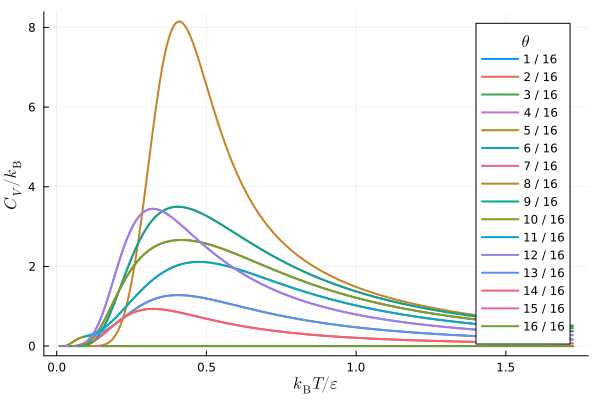

In [6]:
# Read data
Cv = CSV.read("data/Cv_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Create an empty plot
p = plot()

# Loop over different numbers of occupied sites
for N in 1:L*M*length(square_basis)

    # Extract the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv))

    # Convert the temperatures to reduced units
    Ts = kB * df_N.T / ustrip(-nn_energy)

    # Extract the constant-volume heat capacity data
    Cv_N = df_N.Cv

    # Create a plot of the constant-volume heat capacity as a function of temperature
    plot!(p, Ts, Cv_N, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel="\$ C_V / k_{\\mathrm{B}} \$", linewidth=2, size=(600, 400), label="$(N) / $(L * M)", legendtitle="\$ \\theta \$", color=N)
    
end

# Display the plot
display(p)

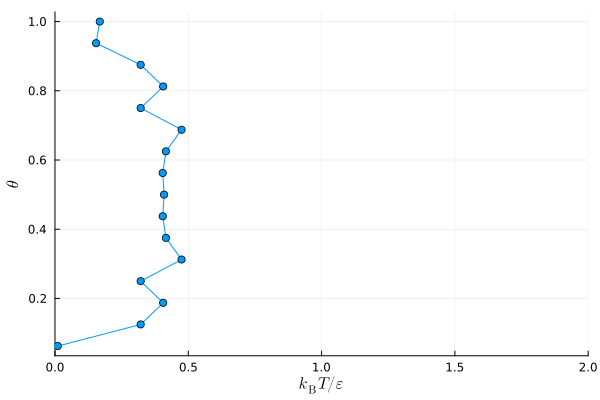

In [7]:
# Read data
Cv_neighbor_list = CSV.read("data/Cv_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Create an empty DataFrame to store N and T_max
peak_df = DataFrame(N = Int[], T_max = Float64[])

# Loop over different numbers of occupied sites
for N in 1:L*M*length(square_basis)

    # Filter the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv_neighbor_list))

    # Remove the rows with NaN values in the Cv column
    df_N = df_N[.!isnan.(df_N.Cv), :]

    # Check if dataframe is empty
    if !isempty(df_N)
        # Find the index of the maximum heat capacity
        idx_max_Cv = argmax(df_N.Cv)
        
        # Find the temperature corresponding to the maximum heat capacity
        T_max = df_N.T[idx_max_Cv]
        
        # Append to the DataFrame
        push!(peak_df, (N, T_max))
    end
end

# Save the DataFrame to a CSV file
CSV.write("data/peak_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", peak_df)

# Plotting
Trs = kB * peak_df.T_max / ustrip(-nn_energy)
θs = peak_df.N / (L * M)
p = plot(Trs, θs, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel = "\$ \\theta \$", marker = :circle, legend = false, xlim=(0, 2))
display(p)